# Similarity Network Fusion

This notebook is a demonstration of how to integrate select modalities for training with MOGDx

In [13]:
# Importing the libraries

import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from palettable import wesanderson
import sys
sys.path.insert(0 , './../MAIN/')
from utils import *
import preprocess_functions

In [19]:
# Specify modalities and parameters

modalities = ['mRNA'  ,'miRNA' , 'DNAm']
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'


 Performing SNF for Modality Combinations with 3 modalities 

SNF network for DNAm and mRNA and miRNA


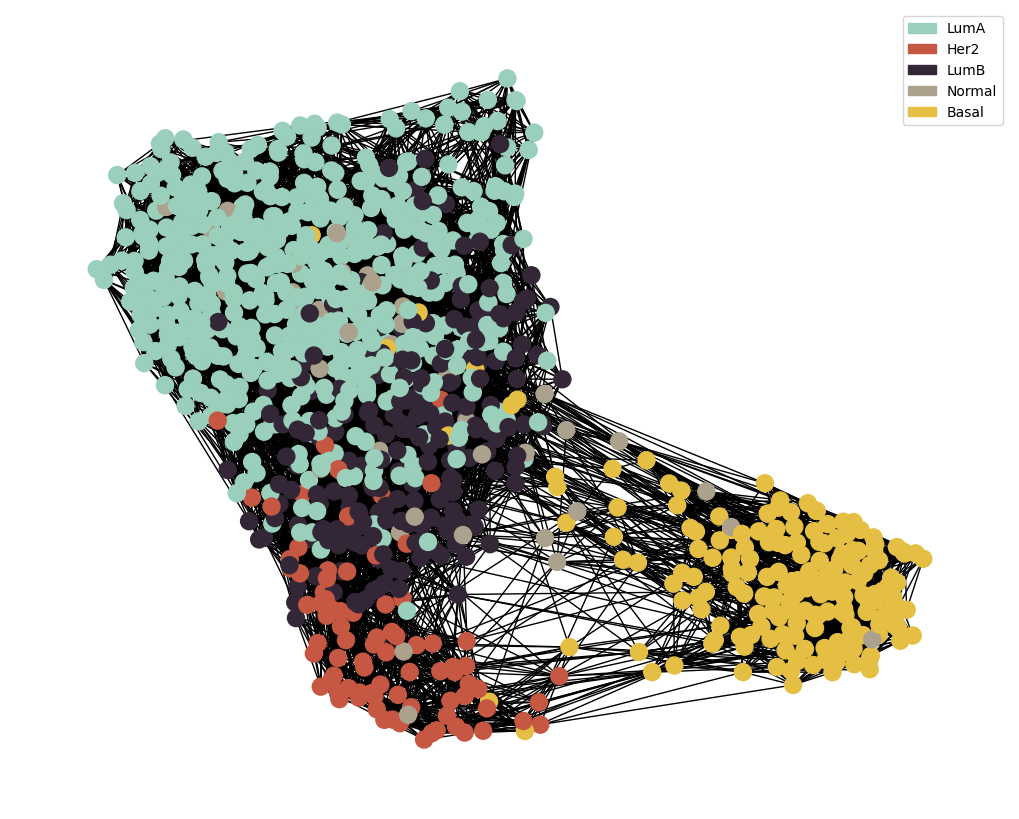

In [20]:
for n_mods in range(3,4) : 
    print(f'\n Performing SNF for Modality Combinations with {n_mods} modalities \n')
    for mods in itertools.combinations(sorted(modalities) , n_mods) :
        print(f'SNF network for {" and ".join(mods)}')
        all_graphs = {}
        all_idx = []
        for i , mod in enumerate(mods) : 
            with open(f'./../../data/TCGA/BRCA/raw/{mod}_processed.pkl', 'rb') as file:
                loaded_data = pickle.load(file)

            if i == 0 : 
                datMeta = loaded_data['datMeta'].reset_index()
            else : 
                datMeta = pd.merge(datMeta , loaded_data['datMeta'].reset_index() , how = 'outer'  , on = [index_col , target])

            all_graphs[mod] =  nx.read_graphml(f'./../../data/TCGA/BRCA/Networks/{mod}_graph.graphml')
            all_idx.extend(list(all_graphs[mod].nodes))

        datMeta = datMeta.set_index(index_col)
        all_idx = list(set(all_idx))

        full_graphs = []

        for mod , graph in all_graphs.items() : 
            full_graph = pd.DataFrame(data = np.zeros((len(all_idx) , len(all_idx))) , index=sorted(all_idx) , columns=sorted(all_idx))
            graph = nx.to_pandas_adjacency(graph)
            full_graph.loc[graph.index , graph.index] = graph.values

            full_graphs.append(full_graph)

        #for knn in [1,5,7,10,15,20,25,50] : 
        #for t in [1,2,5,7,10,15,20,50] :
        adj_snf = preprocess_functions.SNF(full_graphs , K=15 , t=5)
        #adj_snf = sum(full_graphs)/3
        #adj_snf = 0.3*full_graphs[0] + 0.35*full_graphs[1] + 0.35*full_graphs[2]

        node_labels = pd.Series(adj_snf.index) 

        node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

        G  = preprocess_functions.gen_knn_network(adj_snf , 15 , datMeta.loc[adj_snf.index][target] ,
                                                               node_colours=node_colour , node_size=150 , plot=True)
        snf_name = '_'.join(sorted(modalities))
        #nx.write_graphml(G, f'./../../data/TCGA/BRCA/ThesisExpts/SNFOptimisation/SNF_{knn}_{t}_graph.graphml')
        #nx.write_graphml(G, f'./../../data/TCGA/BRCA/ThesisExpts/NetworkFusion/SNF_{knn}_graph.graphml')
        nx.write_graphml(G, f'./../../data/TCGA/BRCA/Networks/{snf_name}_graph.graphml')

In [ ]:
graph = 'RPPA_mRNA'
G= network_from_csv(f'./../../data/Networks/{graph}_graph.csv' , False)

node_colours = datMeta.loc[list(G.nodes)][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

labels = datMeta.loc[list(G.nodes)][target]

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, font_weight='bold', node_size=150, node_color=node_colours, font_size=8)
patches = []
for col , lab in zip(node_colours.unique() , labels.unique()) : 
    patches.append(mpatches.Patch(color=col, label=lab))
plt.legend(handles=patches)
plt.show()                                            

nx.set_node_attributes(G, labels.astype('category').cat.codes , 'label')

#nx.write_graphml(G, f'./../../data/Networks/{graph}_graph.graphml')

In [ ]:
G_PY = nx.read_graphml(f'./../../data/Networks/RPPA_mRNA_graph.graphml')
node_colours = datMeta.loc[list(G_PY.nodes)][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

labels = datMeta.loc[list(G_PY.nodes)][target]

plt.figure(figsize=(10, 8))
nx.draw(G_PY, with_labels=False, font_weight='bold', node_size=150, node_color=node_colours, font_size=8)
patches = []
for col , lab in zip(node_colours.unique() , labels.unique()) : 
    patches.append(mpatches.Patch(color=col, label=lab))
plt.legend(handles=patches)
plt.show()  

In [ ]:
node_labels = pd.Series(adj_snf.index) 

node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

G  = preprocess_functions.plot_knn_network(adj_snf , 15 , datMeta.loc[adj_snf.index][target] ,
                                                       node_colours=node_colour , node_size=150)
snf_name = '_'.join(modalities)

nx.write_graphml(G, f'./../../../../data/Networks/{snf_name}_graph.graphml')